In [1]:
import pennylane as qml
import autograd.numpy as np
import matplotlib.pyplot as plt
import time

https://quantumcomputing.stackexchange.com/questions/17637/how-to-create-the-equivalent-of-the-qiskit-rxx-gate-in-pennylane

https://pennylane.readthedocs.io/en/stable/code/api/pennylane.MultiRZ.html

https://discuss.pennylane.ai/t/does-qubitunitary-accept-arraybox/297/2

https://pennylane.ai/blog/2021/05/how-to-add-custom-gates-and-templates-to-pennylane/

In [2]:
n_qubit = 4

In [3]:
import math

INV_SQRT2 = 1 / math.sqrt(2)
c1 = INV_SQRT2 * (np.sqrt(2) + 1) / 4
c2 = INV_SQRT2 * (np.sqrt(2) - 1) / 4
a = np.pi / 2
b = 3 * np.pi / 2
four_term_grad_recipe = ([[c1, 1, a], [-c1, 1, -a], [-c2, 1, b], [c2, 1, -b]],)

In [4]:
import pennylane as qml
from pennylane.operation import Operation
from pennylane import numpy as np

class RXX(Operation):
    num_params = 1
    num_wires = 2
    par_domain = "R"

    grad_method = "A"
    grad_recipe = four_term_grad_recipe # This is the default but we write it down explicitly here.

    generator = [(qml.PauliX(0) @ qml.PauliX(1)).matrix, -0.5]

    @staticmethod
    def decomposition(theta, wires):
        return [qml.PauliRot(theta, 'XX', wires=wires)]

    @staticmethod
    def _matrix(*params):
        theta = params[0]
        c = np.cos(0.5 * theta)
        s = np.sin(0.5 * theta)
        return np.array(
            [
                [c, 0, 0, -s],
                [0, c, -s, 0],
                [0, -s, c, 0],
                [-s, 0, 0, c]
            ]
        )

    def adjoint(self):
        return RXX(-self.data[0], wires=self.wires)

In [5]:
def squeezing(params):
    
    n_qubit = len(params[0])
    
    # RY gate
    for i in range(n_qubit):
        qml.RY(np.pi/2, wires=i)
    
    # GMS_z gate
    for i in range(n_qubit):
        for j in range(i+1, n_qubit):
            qml.MultiRZ(params[0][i][j], wires=[i, j])
    
    # RX gate
    for i in range(n_qubit):
        qml.RX(params[1][0][i], wires=i)
    
    # GMS_x gate
    for i in range(n_qubit):
        for j in range(i+1, n_qubit):
            RXX(params[2][i][j], wires=[i, j])

In [6]:
dev = qml.device('default.mixed', wires=n_qubit)
dev.operations.add("RXX")

@qml.qnode(dev)
def multiple_phase_sensing(params, params_encoded, p):
        
    squeezing(params[:3])
    
    for i in range(4):
        qml.RZ(-params_encoded[2], wires=i)
        qml.RY(-params_encoded[1], wires=i)
        qml.RZ(params_encoded[0], wires=i)
        qml.RY(params_encoded[1], wires=i)
        qml.RZ(params_encoded[2], wires=i)
    
    # Noise: 
    # qml.BitFlip(p, wires=0)
    # qml.DepolarizingChannel(p, wires=0)
    # qml.AmplitudeDamping(p, wires=0)
    qml.AmplitudeDamping(p, wires=0)
    qml.AmplitudeDamping(p, wires=1)
    qml.AmplitudeDamping(p, wires=2)
    qml.AmplitudeDamping(p, wires=3)
    
    qml.adjoint(squeezing)(params[3:])
    
    # Measurement 
    return qml.probs(wires=range(len(params[0])))

In [7]:
def fisher_shift_rule(i, j, params, params_encoded, shift, p):
    
    sum_diff = 0
    probs = multiple_phase_sensing(params, params_encoded, p)
    
    params_encoded_i_plus = params_encoded.copy()
    params_encoded_i_subs = params_encoded.copy()
    params_encoded_j_plus = params_encoded.copy()
    params_encoded_j_subs = params_encoded.copy()

    params_encoded_i_plus[i] = params_encoded_i_plus[i] + shift
    params_encoded_i_subs[i] = params_encoded_i_subs[i] - shift
    params_encoded_j_plus[j] = params_encoded_j_plus[j] + shift
    params_encoded_j_subs[j] = params_encoded_j_subs[j] - shift

    diff_i = (multiple_phase_sensing(params, params_encoded_i_plus, p) - multiple_phase_sensing(params, params_encoded_i_subs, p))/(2*np.sin(shift))
    diff_j = (multiple_phase_sensing(params, params_encoded_j_plus, p) - multiple_phase_sensing(params, params_encoded_j_subs, p))/(2*np.sin(shift))
        
    for k in range(len(probs)):
        
        if probs[k] != 0:
            sum_diff += diff_i[k]*diff_j[k]/probs[k]
        
    return sum_diff

In [8]:
def fisher_matrix(params, params_encoded, shift, p):
    n = len(params_encoded)
    results = [[fisher_shift_rule(i, j, params, params_encoded, shift, p) for j in range(n)] for i in range(n)]
    return np.array(results)

In [22]:
def cost(params):
    global params_encoded
    
    # Noise: ps = [0.001, 0.01, 0.1, 0.2]
    arr = fisher_matrix(params, params_encoded, np.pi/20, 0.2)
    
    return np.trace(np.linalg.inv(arr))

In [10]:
params_encoded = np.array([1.1, 0.7, -0.6])

In [11]:
# params = np.zeros(shape=(6, n_qubit, n_qubit))
params = np.random.normal(size=(6, n_qubit, n_qubit))

In [12]:
params = np.array([[[ 0.99428273,  1.09710887, -0.56566131, -0.06691773],
         [ 1.77189978, -0.36773718,  0.69736815, -1.21426263],
         [ 0.25244028,  0.33687556, -1.33784468,  2.21047394],
         [ 0.3394889 , -1.05655419, -0.7571113 , -1.77781283]],

        [[-0.84773032,  1.83898219,  0.31333539,  0.70865689],
         [-1.02512602, -0.68341346, -0.58727157,  0.24246219],
         [-0.07084525, -0.76039399, -0.21280071, -0.21102259],
         [-0.88367094, -0.16177464, -0.83400285,  0.61017164]],

        [[ 0.53281143, -0.95501388,  2.38233895, -0.29837746],
         [-1.06704017,  0.24286941,  0.73346593,  1.12401983],
         [-0.25551071, -2.03569606, -0.19236259, -0.67839622],
         [ 0.39020518, -0.10392657, -0.05518679, -0.35891302]],

        [[ 0.12817979, -0.00992391, -0.00364549, -1.40676109],
         [ 0.05122566,  0.00691019,  0.42308062,  0.99433363],
         [ 1.48833531, -0.33839754, -2.0910268 ,  0.53049627],
         [-0.8858284 ,  0.09423672, -1.82323287, -0.41916103]],

        [[-0.55314528,  0.36325934, -0.31057847,  0.13886429],
         [-0.33743291,  0.07965355,  1.20437349,  0.23126415],
         [ 2.50047872,  1.12006902,  0.87573478, -0.43730202],
         [ 1.41811439,  0.316319  ,  0.61662017,  0.94854172]],

        [[ 1.30664094, -0.48438619,  0.43446318, -0.74382484],
         [ 0.163874  , -2.89143975,  1.22669873,  0.03160277],
         [ 1.01211061, -0.96099056, -2.15876514, -0.27013816],
         [ 1.8390521 ,  0.12355094,  1.2428606 , -0.53097397]]])

params

tensor([[[ 0.99428273,  1.09710887, -0.56566131, -0.06691773],
         [ 1.77189978, -0.36773718,  0.69736815, -1.21426263],
         [ 0.25244028,  0.33687556, -1.33784468,  2.21047394],
         [ 0.3394889 , -1.05655419, -0.7571113 , -1.77781283]],

        [[-0.84773032,  1.83898219,  0.31333539,  0.70865689],
         [-1.02512602, -0.68341346, -0.58727157,  0.24246219],
         [-0.07084525, -0.76039399, -0.21280071, -0.21102259],
         [-0.88367094, -0.16177464, -0.83400285,  0.61017164]],

        [[ 0.53281143, -0.95501388,  2.38233895, -0.29837746],
         [-1.06704017,  0.24286941,  0.73346593,  1.12401983],
         [-0.25551071, -2.03569606, -0.19236259, -0.67839622],
         [ 0.39020518, -0.10392657, -0.05518679, -0.35891302]],

        [[ 0.12817979, -0.00992391, -0.00364549, -1.40676109],
         [ 0.05122566,  0.00691019,  0.42308062,  0.99433363],
         [ 1.48833531, -0.33839754, -2.0910268 ,  0.53049627],
         [-0.8858284 ,  0.09423672, -1.82323287, 

In [13]:
params_bitflip_0 = params.copy()
params_bitflip_1 = params.copy()
params_bitflip_2 = params.copy()
params_bitflip_3 = params.copy()

In [14]:
cost(params_bitflip_0)

22.023696679907104

In [15]:
start = time.time()
opt = qml.AdamOptimizer()
costs_array_bitflip_0 = [cost(params_bitflip_0)]
steps = 50
for i in range(steps):
    params_bitflip_0 = opt.step(cost, params_bitflip_0)
    costs_array_bitflip_0.append(cost(params_bitflip_0))
time.time() - start

2554.637347459793

In [17]:
cost(params_bitflip_1)

23.43288351576012

In [18]:
start = time.time()
opt = qml.AdamOptimizer()
costs_array_bitflip_1 = [cost(params_bitflip_1)]
steps = 50
for i in range(steps):
    params_bitflip_1 = opt.step(cost, params_bitflip_1)
    costs_array_bitflip_1.append(cost(params_bitflip_1))
time.time() - start

2655.363580226898

In [20]:
cost(params_bitflip_2)

42.708722708096

In [21]:
start = time.time()
opt = qml.AdamOptimizer()
costs_array_bitflip_2 = [cost(params_bitflip_2)]
steps = 50
for i in range(steps):
    params_bitflip_2 = opt.step(cost, params_bitflip_2)
    costs_array_bitflip_2.append(cost(params_bitflip_2))
time.time() - start

2399.514009475708

In [23]:
cost(params_bitflip_3)

83.84050617476728

In [24]:
start = time.time()
opt = qml.AdamOptimizer()
costs_array_bitflip_3 = [cost(params_bitflip_3)]
steps = 50
for i in range(steps):
    params_bitflip_3 = opt.step(cost, params_bitflip_3)
    costs_array_bitflip_3.append(cost(params_bitflip_3))
time.time() - start

2889.409077644348

In [33]:
params

tensor([[[ 0.99428273,  1.09710887, -0.56566131, -0.06691773],
         [ 1.77189978, -0.36773718,  0.69736815, -1.21426263],
         [ 0.25244028,  0.33687556, -1.33784468,  2.21047394],
         [ 0.3394889 , -1.05655419, -0.7571113 , -1.77781283]],

        [[-0.84773032,  1.83898219,  0.31333539,  0.70865689],
         [-1.02512602, -0.68341346, -0.58727157,  0.24246219],
         [-0.07084525, -0.76039399, -0.21280071, -0.21102259],
         [-0.88367094, -0.16177464, -0.83400285,  0.61017164]],

        [[ 0.53281143, -0.95501388,  2.38233895, -0.29837746],
         [-1.06704017,  0.24286941,  0.73346593,  1.12401983],
         [-0.25551071, -2.03569606, -0.19236259, -0.67839622],
         [ 0.39020518, -0.10392657, -0.05518679, -0.35891302]],

        [[ 0.12817979, -0.00992391, -0.00364549, -1.40676109],
         [ 0.05122566,  0.00691019,  0.42308062,  0.99433363],
         [ 1.48833531, -0.33839754, -2.0910268 ,  0.53049627],
         [-0.8858284 ,  0.09423672, -1.82323287, 

In [25]:
import pandas as pd

In [26]:
pd.DataFrame({'Column0': costs_array_bitflip_0, 
              'Column1': costs_array_bitflip_1, 
              'Column2': costs_array_bitflip_2, 
              'Column3': costs_array_bitflip_3}).to_csv('costs_array_amplitudedamping.csv')

In [27]:
df_amplitudedamping = pd.read_csv('costs_array_amplitudedamping.csv')
df_bitflip = pd.read_csv('costs_array_bitflip.csv')
df_depolarizingchannel = pd.read_csv('costs_array_depolarizingchannel.csv')

In [28]:
import matplotlib.pyplot as plt

In [29]:
steps = 50

In [30]:
SIZE = 34*2
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

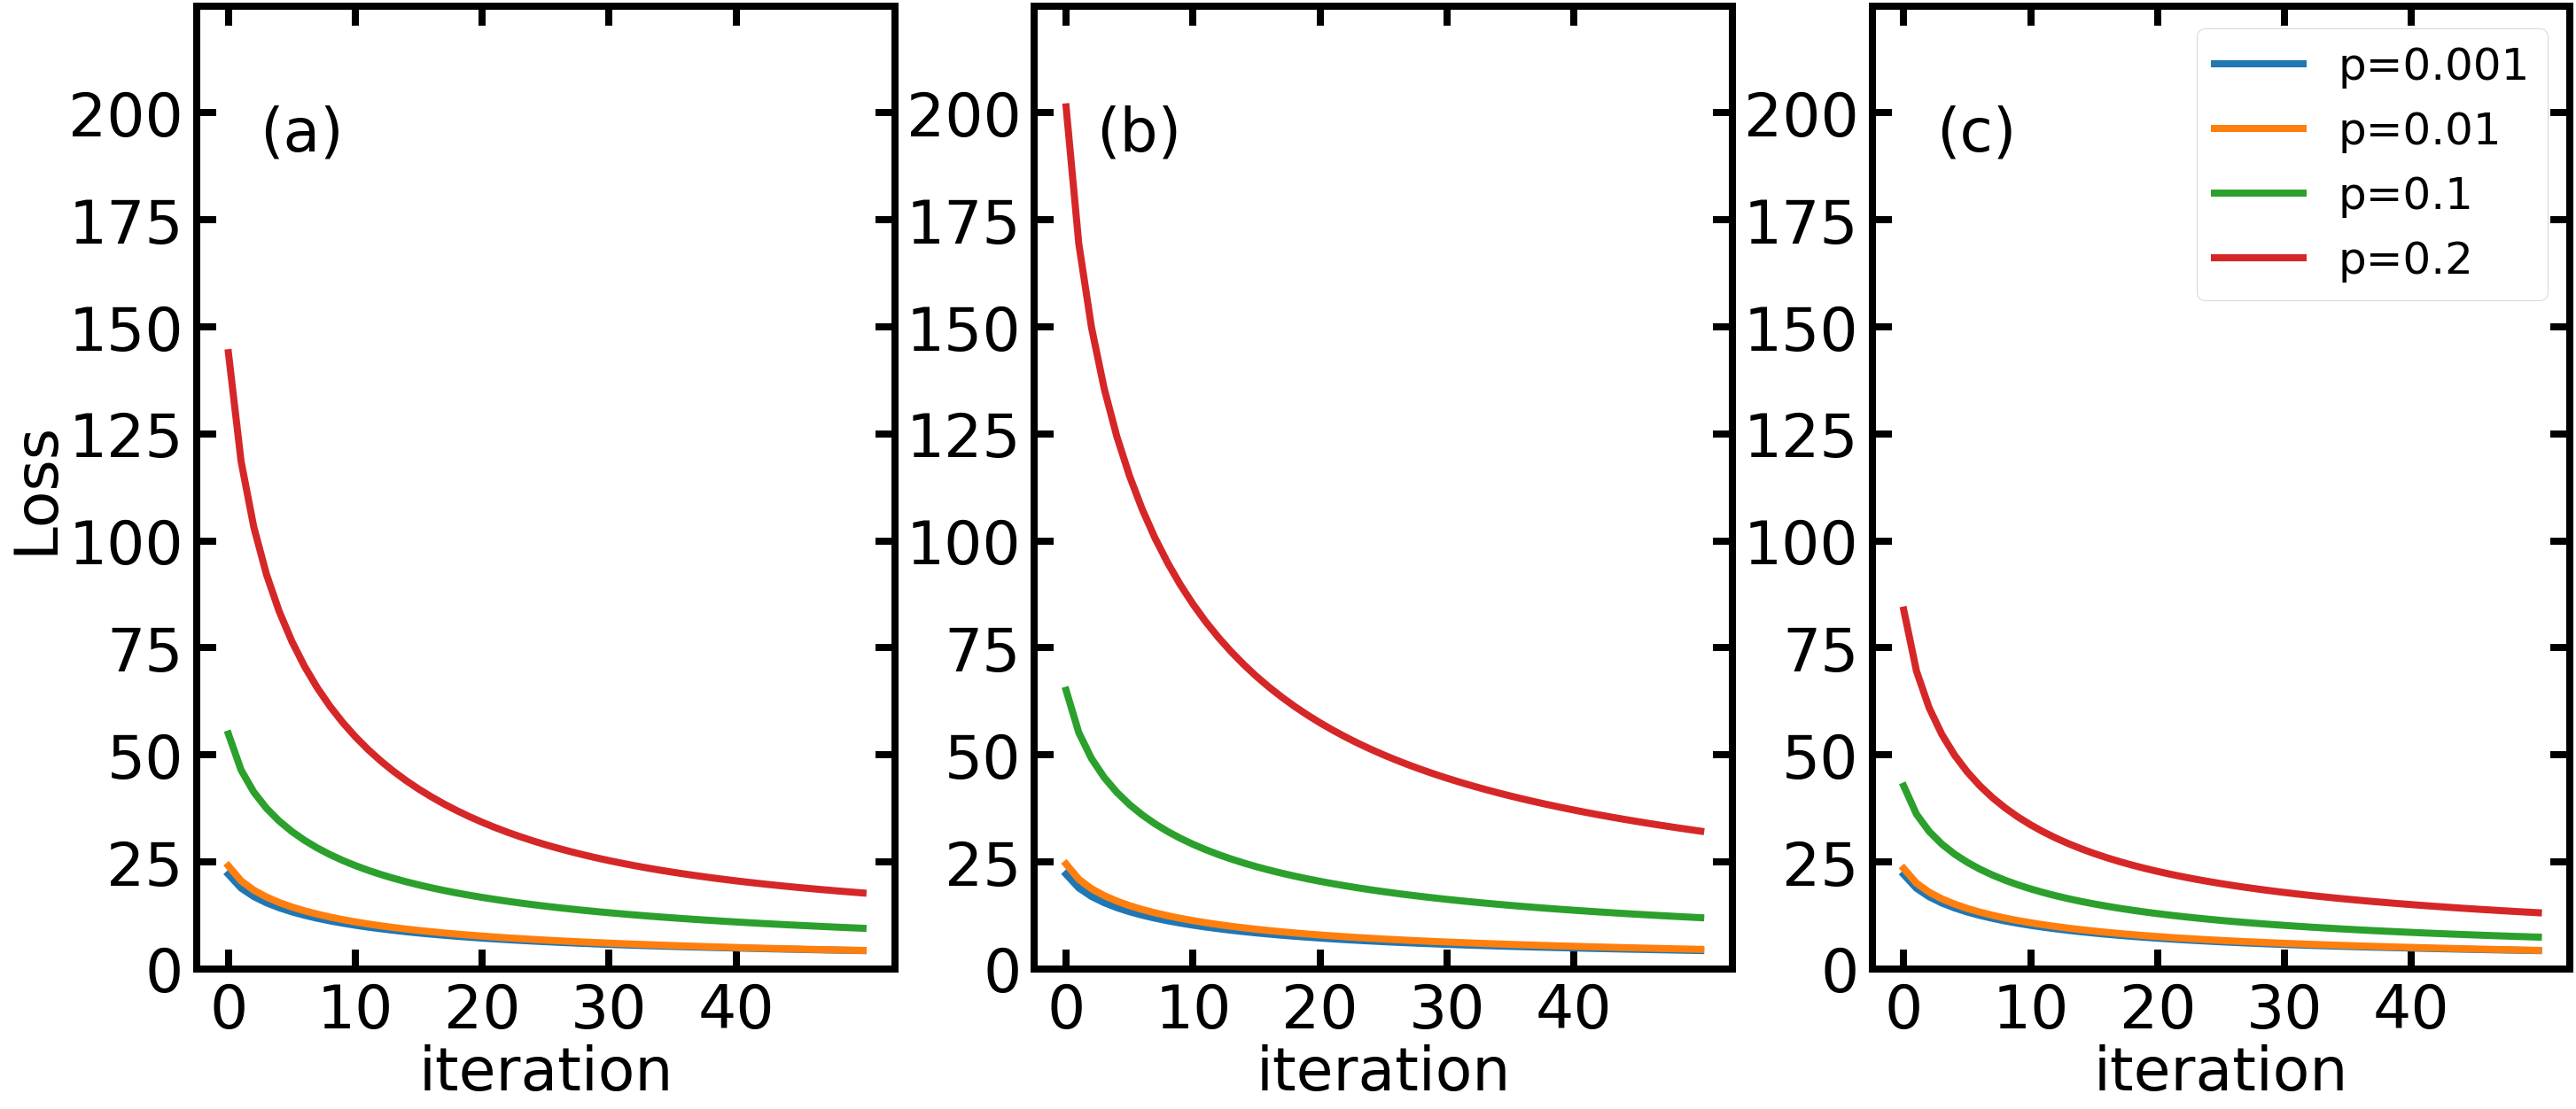

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(60*0.8, 20), linewidth=8)

# BitFlip
axes[0].plot(range(steps+1), df_bitflip['Column0'], linewidth=8, label='p=0.001')
axes[0].plot(range(steps+1), df_bitflip['Column1'], linewidth=8, label='p=0.01')
axes[0].plot(range(steps+1), df_bitflip['Column2'], linewidth=8, label='p=0.1')
axes[0].plot(range(steps+1), df_bitflip['Column3'], linewidth=8, label='p=0.2')

axes[0].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[0].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[0].tick_params(top=True, right=True)
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('Loss')
axes[0].text(.15,0.85,'(a)',
        horizontalalignment='center',
        transform=axes[0].transAxes)
for axis in ['top','bottom','left','right']:
    axes[0].spines[axis].set_linewidth(8)
    axes[0].spines[axis].set_zorder(0)
axes[0].set_ylim(0, 225)
axes[0].set_xticks(np.arange(0, 50, 10))
axes[0].set_yticks(np.arange(0, 225, 25))

# Depolarizing Channel
axes[1].plot(range(steps+1), df_depolarizingchannel['Column0'], linewidth=8, label='p=0.001')
axes[1].plot(range(steps+1), df_depolarizingchannel['Column1'], linewidth=8, label='p=0.01')
axes[1].plot(range(steps+1), df_depolarizingchannel['Column2'], linewidth=8, label='p=0.1')
axes[1].plot(range(steps+1), df_depolarizingchannel['Column3'], linewidth=8, label='p=0.2')

axes[1].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[1].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[1].tick_params(top=True, right=True)
axes[1].set_xlabel('iteration')
# axes[1].set_ylabel('Loss')
axes[1].text(.15,0.85,'(b)',
        horizontalalignment='center',
        transform=axes[1].transAxes)
for axis in ['top','bottom','left','right']:
    axes[1].spines[axis].set_linewidth(8)
    axes[1].spines[axis].set_zorder(0)
axes[1].set_ylim(0, 225)
axes[1].set_xticks(np.arange(0, 50, 10))
axes[1].set_yticks(np.arange(0, 225, 25))

# Amplitude Damping
axes[2].plot(range(steps+1), df_amplitudedamping['Column0'], linewidth=8, label='p=0.001')
axes[2].plot(range(steps+1), df_amplitudedamping['Column1'], linewidth=8, label='p=0.01')
axes[2].plot(range(steps+1), df_amplitudedamping['Column2'], linewidth=8, label='p=0.1')
axes[2].plot(range(steps+1), df_amplitudedamping['Column3'], linewidth=8, label='p=0.2')

axes[2].tick_params(axis="x", which = 'major', direction="in", length=22, width=8, pad=15)
axes[2].tick_params(axis="y", which = 'major', direction="in", length=22, width=8, pad=15)
axes[2].tick_params(axis="y", which = 'minor', direction="in", length=8, width=8, pad=15)
axes[2].tick_params(top=True, right=True)
axes[2].set_xlabel('iteration')
# axes[2].set_ylabel('Loss')
axes[2].text(.15,0.85,'(c)',
        horizontalalignment='center',
        transform=axes[2].transAxes)
axes[2].legend(loc='upper right', fontsize=50)
for axis in ['top','bottom','left','right']:
    axes[2].spines[axis].set_linewidth(8)
    axes[2].spines[axis].set_zorder(0)
axes[2].set_ylim(0, 225)
axes[2].set_xticks(np.arange(0, 50, 10))
axes[2].set_yticks(np.arange(0, 225, 25))

plt.savefig('squeezing_noise.png')
plt.savefig('squeezing_noise.eps', format='eps')